<a href="https://colab.research.google.com/github/ajlukasiewicz/Team_9_MacLearn/blob/Muyoung/Prediction_of_plant_associated_bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting plant associated bacterial from genetic markers**

The soil microbiome is a diverse and sensitive assembly of organisms (bacterial and fungal) whose composition changes relative to the soil type, location, and even the plant species. 

Based on a large dataset of 3800, well-curated, bacterial genomes (Levy et. al., 2017) we aimed to construct a classifier of bacteria, based on three major feature families: Carbohydrate Associated Enzyme families, COG counts, and the % of horizontally transmitted genes within each bacterial genome. 

Carbohydrate associated enzymes were identified for each genome using the DBCan4 tool, and COG percentages were calculated from the metadata provided by Levy et. al., 2017. 

Authors of this project are Muyoung Lee (ML), Sarah Coleman (SC), and Alexandra Lukasiewicz (AL) to fulfill the requirements of our final project in SDS 384, Scientific Machine Learning. 

We each have contributed equally to the review, curation, writing and interpretation of this project. This colab document represents the aggregate of all individual scripts used to modify, train, tune, and evaluate multiple models. For more information on our individual approaches, please see the jupyter notebooks in each of our git branches. 

We have included author contributions in the #comments for each script section.

In [72]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

#normalization
from sklearn.preprocessing import StandardScaler

#splitting and feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost as xgb

#evaluation
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, PrecisionRecallDisplay, precision_recall_curve

#shhhhhh
import warnings
warnings.filterwarnings('ignore')

In [73]:
#functions
def soilrm(df):
    df2 = df[df["Classification"] != "soil"]
    soil = df[df["Classification"] == "soil"]
    return df2, soil

In [74]:
#set matplotlib theme 
custom_style = {
    'figure.figsize': (8, 6),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'font.serif': ['arial'],
    'text.color': '#333333',
    'axes.edgecolor': '#CCCCCC',
    'axes.linewidth': 1.5,
    'grid.linewidth': 0.5,
    'grid.color': '#DDDDDD',
}


In [ ]:
#AL
#import data
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Datasets/"

dbcan = pd.read_csv(data_dir + "dbcan_result.3772genomes.matrix.divided_by_gene_counts.tsv", sep="\t")
cog = pd.read_csv(data_dir + "cog_ratios.csv")
metadata = pd.read_csv(data_dir + "jgi_metadata_processed.csv")

#overlapping features from all three of our feature selection approaches
union_features = pd.read_csv(data_dir + "overlapping_features.csv")
union_features = union_features['elements'].values

In [76]:
#AL
#modify and merge hgt% to dbcan dataset
dbcan = dbcan.rename(columns = {"taxonID" : "2016_taxon_oid"})

#add hgt % from metadata to dbcan dataset
dbcan = pd.merge(dbcan, cog[['2016_taxon_oid', 'Horizontally_Transferred_%']], 
                             on='2016_taxon_oid', 
                             how='left')

In [77]:
#AL
#remove soil bacteria from all three datasets 
cog, soilcog = soilrm(cog)

dbcan, soilcan = soilrm(dbcan)

In [78]:
#AL
#merge the dbcan and cog datasets
columns = ['Classification', 'Horizontally_Transferred_%', "Gene_Count___*_assembled", "Unnamed: 0"]
merged = pd.merge(dbcan, cog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

merged.head()

,2016_taxon_oid,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
#AL
#x and y variables
variables = merged.columns[:4]
classif = dbcan['Classification']

scaler = StandardScaler()
merged_n = pd.DataFrame(scaler.fit_transform(merged.iloc[:,4:]), columns = merged.iloc[:,4:].columns)
merged_n.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738


The classifications appear to be roughly 65% NPA, and 35% PA. We therefore stratify our training and testing datasets by the classification



In [80]:
#Train test split dataset, scaled by classification ()
X_train, X_test, y_train, y_test = train_test_split(merged_n,
                                                    classif, test_size=0.33,
                                                    random_state=42, 
                                                    stratify=classif)

In [81]:
#ML, AL, SC
#filter the main, training, and test datasets by the union features
X = merged_n[union_features]
X_train = X_train[union_features]
X_test = X_test[union_features]

In [82]:
#ML 
#Decision tree model building and evaluation 

'''
twenty = [i for i in range(1, 20+1)]
accuracies = {}

for depth in twenty:
  for _min_samples_leaf in twenty:
    clf1 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
    clf1.fit(X_train, y_train)
    y_pred1 = clf1.predict(X_test)
    accuracies[(depth, _min_samples_leaf)] = metrics.accuracy_score(y_test, y_pred1)

sorted_accuracies = sorted(accuracies.items(), key=lambda x:x[1], reverse=True)
depth, _min_samples_leaf = sorted_accuracies[0][0]
print(depth, _min_samples_leaf)
'''
depth, _min_samples_leaf = 11, 5  # Based on the former result, to save time
clf1 = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
clf1.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)

# Accuracy scores measured with the test set and train set
print(metrics.accuracy_score(y_test, y_pred1))
print(metrics.accuracy_score(y_train, clf1.predict(X_train)))

dt_depth = depth
dt_min_samples_leaf = _min_samples_leaf

0.8477251624883937
0.9624542124542125


In [83]:
#ML
#Random Forest model building and evaluation

'''
twenty = [i for i in range(1, 20+1)]
accuracies = {}

for _n_estimators in [50, 100, 150]:
  for depth in twenty:
    for _min_samples_leaf in twenty:
      clf2 = RandomForestClassifier(n_estimators=_n_estimators, max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
      clf2.fit(X_train, y_train.values.ravel())
      y_pred2 = clf2.predict(X_test)
      accuracies[(_n_estimators, depth, _min_samples_leaf)] = metrics.accuracy_score(y_test, y_pred2)

sorted_accuracies = sorted(accuracies.items(), key=lambda x:x[1], reverse=True)
_n_estimators, depth, _min_samples_leaf = sorted_accuracies[0][0]
print(_n_estimators, depth, _min_samples_leaf)
'''
_n_estimators, depth, _min_samples_leaf = 50, 18, 1 # Based on the former result, to save time
clf2 = RandomForestClassifier(n_estimators=_n_estimators, max_depth=depth, min_samples_leaf=_min_samples_leaf, random_state=42)
clf2.fit(X_train, y_train.values.ravel())
y_pred2 = clf2.predict(X_test)

# Accuracy scores measured with the test set and train set
print(metrics.accuracy_score(y_test, y_pred2))
print(metrics.accuracy_score(y_train, clf2.predict(X_train)))

RF_n_estimators, RF_depth, RF_min_samples_leaf = _n_estimators, depth, _min_samples_leaf

0.8885793871866295
0.9995421245421245


In [84]:
#ML
#XGBoost model building and evaluation
XGB_y_test = y_test.replace("PA", 1).replace("NPA", 0)
XGB_y_train = y_train.replace("PA", 1).replace("NPA", 0)

'''
twenty = [i for i in range(1, 20+1)]
accuracies = {}

for _n_estimators in [50, 100, 150]:
  for depth in twenty:
    clf3 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=_n_estimators, max_depth=depth, random_state=42)
    clf3.fit(X_train, XGB_y_train)
    y_pred3 = clf3.predict(X_test)
    accuracies[(_n_estimators, depth)] = metrics.accuracy_score(XGB_y_test, y_pred3)

sorted_accuracies = sorted(accuracies.items(), key=lambda x:x[1], reverse=True)
_n_estimators, depth = sorted_accuracies[0][0]
print(_n_estimators, depth)
'''
_n_estimators, depth = 150, 8 # Based on the former result, to save time

clf3 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=_n_estimators, max_depth=depth, random_state=42)
clf3.fit(X_train, XGB_y_train)
y_pred3 = clf3.predict(X_test)

# Accuracy scores measured with the test set and train set
print(metrics.accuracy_score(XGB_y_test, y_pred3))
print(metrics.accuracy_score(XGB_y_train, clf3.predict(X_train)))

XGB_n_estimators, XGB_depth = _n_estimators, depth

0.8997214484679665
1.0


In [85]:
#ML

# To check whether the first column from predict_proba is about PA or not (NPA).
#Tree
print(clf1.classes_)
#RF
print(clf2.classes_)
# XGBoost
print(clf3.classes_)

['NPA' 'PA']
['NPA' 'PA']
[0 1]


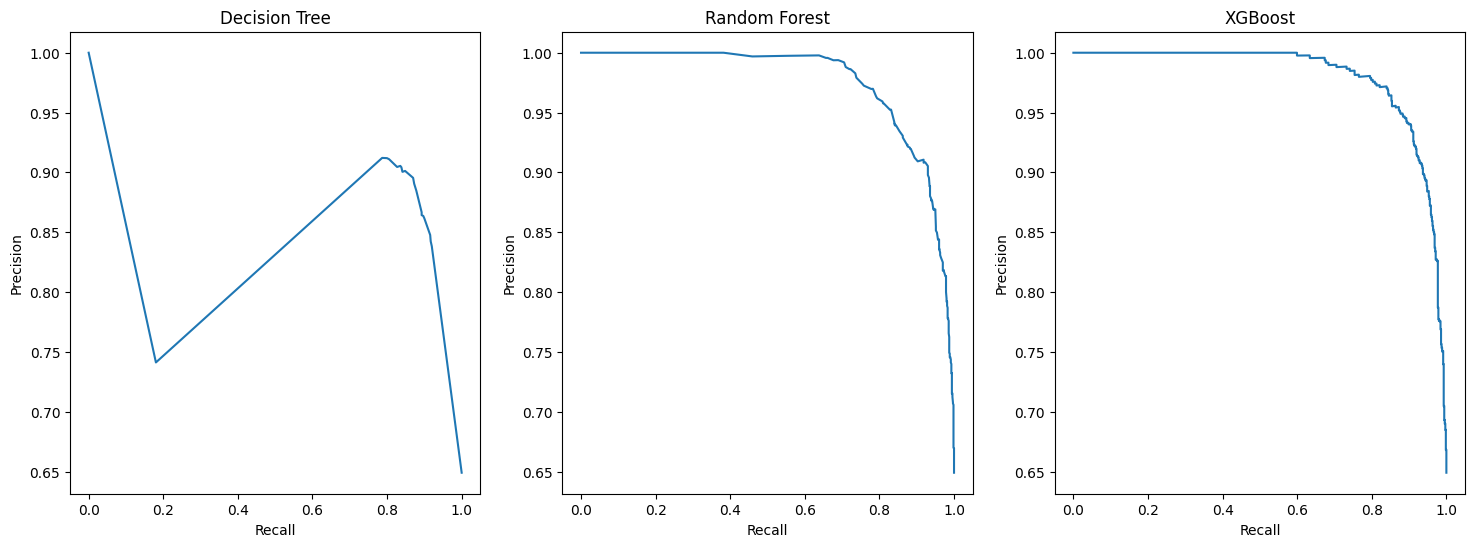

In [86]:
#ML
#Random Forest and Decision Tree PR curves


#generate curves
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, clf1.predict_proba(X_test)[:,0], pos_label="NPA")
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, clf2.predict_proba(X_test)[:,0], pos_label="NPA")
precision_3, recall_3, thresholds_3 = precision_recall_curve(XGB_y_test, clf3.predict_proba(X_test)[:,0], pos_label=0)

#plot
fig, ax = plt.subplots(1,3, figsize=(18, 6))

ax[0].plot(recall_1, precision_1)
ax[1].plot(recall_2, precision_2)
ax[2].plot(recall_3, precision_3)

ax[0].set_title("Decision Tree")
ax[1].set_title("Random Forest")
ax[2].set_title("XGBoost")

ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[2].set_xlabel("Recall")
ax[2].set_ylabel("Precision")

plt.show()

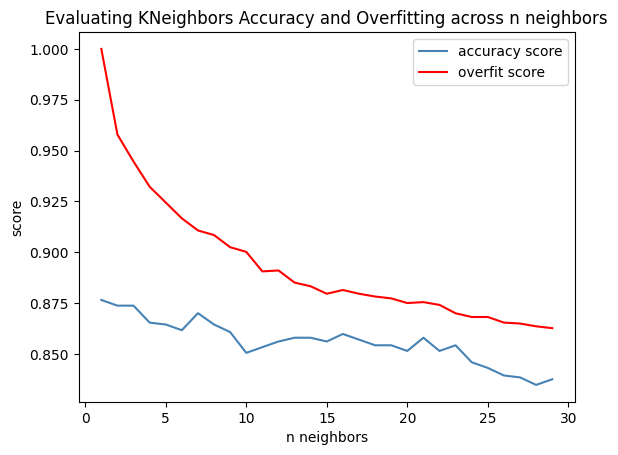

In [87]:
#AL
#train and evaluate KNeighbors Classification
#list of feature k to try
neighbors = range(1,30)
accuracy = {"n": [], "accuracy": [], "overfit": []}

for n in neighbors:
    #fit
    KNC = KNeighborsClassifier(n_neighbors = n)
    KNC.fit(X_train, y_train)

    # select the same features on the test set, predict, and get the test accuracy:
    y_pred = KNC.predict(X_test)

    #log accuracy
    accuracy['n'].append(n)
    accuracy['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
    accuracy['overfit'].append(KNC.score(X_train, y_train))

accuracy_dataframe = pd.DataFrame.from_dict(accuracy)

#plot  
plt.plot(accuracy_dataframe['n'], accuracy_dataframe['accuracy'], label='accuracy score', color = 'steelblue')
plt.plot(accuracy_dataframe['n'], accuracy_dataframe['overfit'], label='overfit score', color = 'red')

# add a title and labels to the plot
plt.xlabel('n neighbors')
plt.ylabel('score')
plt.title('Evaluating KNeighbors Accuracy and Overfitting across n neighbors')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

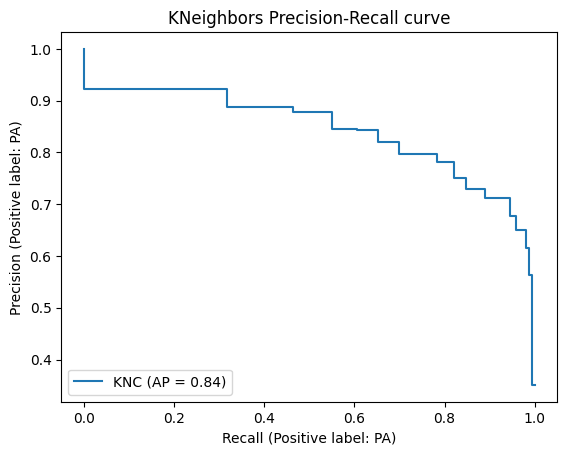

In [88]:
#AL 
#fit KNeighbors at n = 15
KNC = KNeighborsClassifier(n_neighbors = 15)
KNC.fit(X_train, y_train)

#KNeighbors PRcurves
display = PrecisionRecallDisplay.from_estimator(
    KNC, X_test, y_test, name="KNC"
)
_ = display.ax_.set_title("KNeighbors Precision-Recall curve")

In [89]:
#SC
# Train Logistic Regression Model - 3 Versions

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

clf = LogisticRegression(random_state=42, max_iter = 500, penalty = 'l2').fit(X_train, y_train)
clf2 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(X_train, y_train)
clf3 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'l1', solver = 'saga').fit(X_train, y_train)

y_pred_1 = clf.predict_proba(X_test)
y_pred_2 = clf2.predict_proba(X_test)
y_pred_3 = clf3.predict_proba(X_test)

print("accuracy score on training data for model 1 " + str(clf.score(X_train, y_train)))
print("accuracy score on training data for model 2 " + str(clf2.score(X_train, y_train)))
print("accuracy score on training data for model 3 " + str(clf3.score(X_train, y_train)))

print("accuracy score on test data for model 1 " + str(clf.score(X_test, y_test)))
print("accuracy score on test data for model 2 " + str(clf2.score(X_test, y_test)))
print("accuracy score on test data for model 3 " + str(clf3.score(X_test, y_test)))

accuracy score on training data for model 1 0.9958791208791209
accuracy score on training data for model 2 0.9940476190476191
accuracy score on training data for model 3 0.9917582417582418
accuracy score on test data for model 1 0.8755803156917363
accuracy score on test data for model 2 0.8792943361188487
accuracy score on test data for model 3 0.8755803156917363


[]

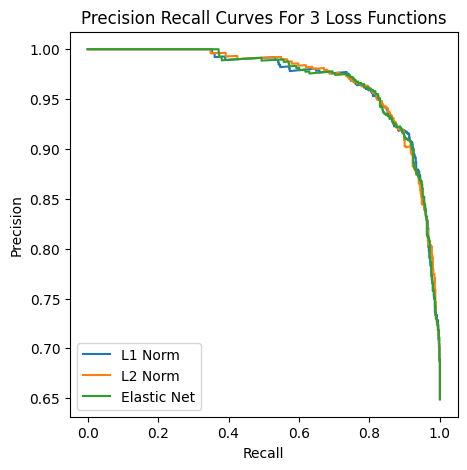

In [90]:
#SC 
#plot pr curves for each model
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = ["NPA"])
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, y_pred_2[:,0], pos_label = ["NPA"])
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, y_pred_3[:,0], pos_label = ["NPA"])

fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_3, precision_3)
ax.plot(recall_1, precision_1)
ax.plot(recall_2, precision_2)
ax.legend(['L1 Norm', 'L2 Norm', 'Elastic Net'])
ax.set_title('Precision Recall Curves For 3 Loss Functions')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

In [91]:
#AL
#Finally, we wanted to perform cross-validation for all 4 models, 
#with the specific parameters we settled upon during individual training and valuation 

X = merged_n[union_features].values
y = classif

#evaluation dict 
cross_val = {"model" : [],
             "accuracy": [], 
             "accuracy_std": [], 
             "precision": [], 
             "precision_std": [], 
             "recall" : [], 
             "recall_std": [],
             "f1" : [],
             "f1_std": [],}

# Create a KFold object with k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store the models; parameters provided by Sarah and Muyoung for their models
models = {
    'LogisticRegression': LogisticRegression(max_iter = 500, penalty = 'l1', solver = 'saga'),
    'KNeighbors': KNeighborsClassifier(n_neighbors=23),
    'DecisionTree': DecisionTreeClassifier(max_depth=dt_depth, min_samples_leaf=dt_min_samples_leaf),
    'RandomForest': RandomForestClassifier(n_estimators=RF_n_estimators, max_depth=RF_depth, min_samples_leaf=RF_min_samples_leaf),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", n_estimators=XGB_n_estimators, max_depth=XGB_depth, random_state=42)
}

# Loop through each model and perform cross-validation
for name, model in models.items():
    accuracies = []
    precision = []
    recall = []
    f1 = []
    roc_auc = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        if name != "XGBoost":
          y_train, y_test = y[train_index], y[test_index]
        else:
          y_train, y_test = y[train_index].replace("PA", 1).replace("NPA", 0), y[test_index].replace("PA", 1).replace("NPA", 0)

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict the labels of the test data
        y_pred = model.predict(X_test)

        # Compute the accuracy score and append it to the list
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        if name != "XGBoost":
          _pos_label = "PA"
        else:
          _pos_label = 1

        #calculate and print the precision
        precision.append(precision_score(y_test, y_pred, pos_label = _pos_label))

        # calculate and print the recall
        recall.append(recall_score(y_test, y_pred, pos_label = _pos_label))

        # calculate and print the F1 score
        f1_sc = f1_score(y_test, y_pred, pos_label = _pos_label)
        f1.append(f1_sc)

    # Compute the mean and standard deviation of the accuracies
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    cross_val["model"].append(name)
    cross_val["accuracy"].append(mean_accuracy)
    cross_val["accuracy_std"].append(std_accuracy)
    cross_val["precision"].append(np.mean(precision)) 
    cross_val["precision_std"].append(np.std(precision)) 
    cross_val["recall"].append(np.mean(recall))
    cross_val["recall_std"].append(np.std(recall))
    cross_val["f1"].append(np.mean(f1))
    cross_val["f1_std"].append(np.std(f1))

cross_val = pd.DataFrame.from_dict(cross_val)
cross_val

,model,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std
0,LogisticRegression,0.910152,0.010274,0.865605,0.026403,0.880510,0.016522,0.872742,0.016442
1,KNeighbors,0.863546,0.014078,0.794880,0.039002,0.823829,0.032979,0.808294,0.025787
2,DecisionTree,0.845753,0.005435,0.779612,0.019538,0.781251,0.021763,0.780059,0.011926
3,RandomForest,0.902794,0.007874,0.869766,0.020956,0.849167,0.014726,0.859267,0.016054
4,XGBoost,0.912607,0.009064,0.877968,0.022677,0.871016,0.016235,0.874375,0.017224


In [92]:
#SC 
#fitting and extracting top features from LR model 
X = merged[union_features]
#X_train = X_train[union_features]
#X_test = X_test[union_features]

#fit
LR = LogisticRegression(max_iter = 500, penalty = 'l1', solver = 'saga')
LR.fit(X, classif)

#predict
LRPredict = LR.predict_proba(X)

#get coefficients and map to features
LR_co = abs(LR.coef_[0])

LR_coeff = pd.concat([pd.DataFrame(union_features), pd.DataFrame(LR_co)], axis = 1)
LR_coeff.index = union_features
LR_coeff.columns = 'Features', 'Coefficents'

LR_coeff.nlargest(100, 'Coefficents')['Coefficents']

COG1609    90.280250
COG0840    48.927525
COG0583    31.502003
COG1309     8.530128
COG4992     0.000000
             ...    
COG2501     0.000000
GH127       0.000000
GH74        0.000000
COG5361     0.000000
COG0297     0.000000
Name: Coefficents, Length: 100, dtype: float64

In [93]:
#SC and ML
#fitting and extracting top features from XGBoost model
X = merged[union_features]

#fit
XGB = xgb.XGBClassifier(objective="binary:logistic", n_estimators=_n_estimators, max_depth=depth, random_state=42)
XGB.fit(X, classif.replace({"PA": 1, "NPA": 0}))

#predict
XGB_Predict = XGB.predict_proba(X)

#get coefficients and map to features
XGB_imp = XGB.feature_importances_

XGB_fea_imp = pd.concat([pd.DataFrame(union_features), pd.DataFrame(XGB_imp)], axis = 1)
XGB_fea_imp.index = union_features
XGB_fea_imp.columns = "Features", "Importance"

XGB_fea_imp.nlargest(100, 'Importance')['Importance']

COG0667    0.145739
COG3131    0.070934
COG1609    0.031649
COG3766    0.031471
COG1703    0.022849
             ...   
COG2244    0.002297
COG3812    0.002295
COG0604    0.002277
COG3023    0.002267
COG1695    0.002259
Name: Importance, Length: 100, dtype: float32

In [94]:
#AL and SC
#applying LR model to soil dataset

#generate soil data
soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

#normalize
scaler = StandardScaler()
soil_norm = pd.DataFrame(scaler.fit_transform(soil_dataset.iloc[:,4:]), columns = soil_dataset.iloc[:,4:].columns)
soil_norm.head()

#extract union features
X_soil = soil_norm[union_features]

#make predictions
LRPredict = LR.predict(X_soil)

soil_dataset['LRPredict'] = LRPredict

In [95]:
#AL, SC and ML
#applying XGB model to soil dataset

#generate soil data
soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

#normalize
scaler = StandardScaler()
soil_norm = pd.DataFrame(scaler.fit_transform(soil_dataset.iloc[:,4:]), columns = soil_dataset.iloc[:,4:].columns)
soil_norm.head()

#extract union features
X_soil = soil_norm[union_features]

#make predictions
XGBPredict = XGB.predict(X_soil)

soil_dataset['XGBPredict'] = XGBPredict

In [96]:
'''
counts = soil_dataset.groupby(['Order','LRPredict']).size().reset_index(name = 'count')

# create a stacked barplot using plotnine
color_values = ['#542788', '#b2abd2','#fdae61']

order_counts = ggplot(counts, aes(x='Order', y='count', fill='LRPredict')) + \
    geom_bar(stat='identity') + \
    labs(x = 'Order', y='Count', fill='Classification') + \
    ggtitle('Classification of soil dataset')+ \
    coord_flip() + \
    scale_fill_manual(values = color_values) + \
    theme_classic()
'''

"\ncounts = soil_dataset.groupby(['Order','LRPredict']).size().reset_index(name = 'count')\n\n# create a stacked barplot using plotnine\ncolor_values = ['#542788', '#b2abd2','#fdae61']\n\norder_counts = ggplot(counts, aes(x='Order', y='count', fill='LRPredict')) +     geom_bar(stat='identity') +     labs(x = 'Order', y='Count', fill='Classification') +     ggtitle('Classification of soil dataset')+     coord_flip() +     scale_fill_manual(values = color_values) +     theme_classic()\n"

In [97]:
counts = soil_dataset.groupby(['Order','XGBPredict']).size().reset_index(name = 'count')

# create a stacked barplot using plotnine
color_values = ['#542788', '#b2abd2','#fdae61']

order_counts = ggplot(counts, aes(x='Order', y='count', fill='XGBPredict')) + \
    geom_bar(stat='identity') + \
    labs(x = 'Order', y='Count', fill='Classification') + \
    ggtitle('Classification of soil dataset')+ \
    coord_flip() + \
    scale_fill_manual(values = color_values) + \
    theme_classic()

In [98]:
counts["XGBPredict"] = counts["XGBPredict"].replace({1: "PA", 0: "NPA"})
counts

,Order,XGBPredict,count
0,Acinetobacter,NPA,4
1,Actinobacteria,NPA,68
2,Actinobacteria,PA,50
3,Alphaproteobacteria,NPA,23
4,Alphaproteobacteria,PA,20
5,Bacillales,NPA,137
6,Bacillales,PA,32
7,Bacteroidetes,NPA,50
8,Bacteroidetes,PA,10
9,Burkholderiales,NPA,38
